In [1]:
"""
  Sofía Almeida Bruno
  https://archive.ics.uci.edu/ml/datasets/optical+recognition+of+handwritten+digits
"""

'\n  Sofía Almeida Bruno\n  https://archive.ics.uci.edu/ml/datasets/optical+recognition+of+handwritten+digits\n'

In [2]:
import numpy as np
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import PolynomialFeatures
from sklearn.feature_selection import SelectFromModel
from sklearn.linear_model import LassoCV
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import accuracy_score

In [3]:
# Leemos los datos de los ficheros
train = np.genfromtxt('./datos/optdigits.tra',  delimiter = ",")
test = np.genfromtxt('./datos/optdigits.tes',  delimiter = ",")

In [4]:
X_train = train[:,0:-1]
y_train = train[:,-1]
X_test= test[:,0:-1]
y_test = test[:,-1]

In [5]:
# Preprocesado----------------------------------------------------------

# Añadimos complejidad al modelo
poly = PolynomialFeatures(2)

# Seleccionamos variables utilizando lasso
lasso = LassoCV(n_jobs = -1, max_iter = 55000, verbose = True, cv = 5)

preprocessing = Pipeline(steps=[
    ('poly', poly),
    ('scale',StandardScaler()),
    ('lasso', SelectFromModel(lasso)),
])

X_train = preprocessing.fit_transform(X_train, y_train)

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.
..............................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................[Parallel(n_jobs=-1)]: Done   2 out of   5 | elapsed:  1.7min remaining:  2.6min
......[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:  1.8min finished


In [6]:
X_train.shape

(3823, 657)

In [7]:
# Ajuste de parámetros
def adjust_params(X, y, model, params):
    print("------ Grid Search...")
    grid = GridSearchCV(model, params, cv=5, n_jobs=-1, verbose=1, scoring='accuracy')
    grid.fit(X, y)
    print("Mejores parámetros:")
    print(grid.best_params_)
    print("Error CV")
    print(grid.best_score_)
    
    print("Grid scores:")
    print()
    means = grid.cv_results_['mean_test_score']
    stds = grid.cv_results_['std_test_score']
    for mean, std, params in zip(means, stds, grid.cv_results_['params']):
        print("%05f (+/-%0.00005f) for %r"
              % (mean, std * 2, params))
    print()
    
    return grid.best_estimator_

In [8]:
lreg = LogisticRegression(penalty = 'l2', tol=0.0001, random_state=123456, solver='saga', multi_class='multinomial', n_jobs=-1)
params_lreg =  {'C':[0.5, 1.0, 2.0], 'max_iter':[250, 500, 1000]}

best_lreg = adjust_params(X_train, y_train, lreg, params_lreg)

------ Grid Search...
Fitting 5 folds for each of 9 candidates, totalling 45 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  45 out of  45 | elapsed: 17.4min finished


Mejores parámetros:
{'C': 0.5, 'max_iter': 500}
Error CV
0.9803836019573623
Grid scores:

0.979338 (+/-0.00968) for {'C': 0.5, 'max_iter': 250}
0.980384 (+/-0.00738) for {'C': 0.5, 'max_iter': 500}
0.980384 (+/-0.00858) for {'C': 0.5, 'max_iter': 1000}
0.979338 (+/-0.00968) for {'C': 1.0, 'max_iter': 250}
0.980122 (+/-0.00763) for {'C': 1.0, 'max_iter': 500}
0.980384 (+/-0.00858) for {'C': 1.0, 'max_iter': 1000}
0.979338 (+/-0.00968) for {'C': 2.0, 'max_iter': 250}
0.980122 (+/-0.00763) for {'C': 2.0, 'max_iter': 500}
0.980384 (+/-0.00858) for {'C': 2.0, 'max_iter': 1000}



/home/sofia/.local/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:329: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "


In [9]:
# Preprocesamos el conjunto de test 
X_test = preprocessing.transform(X_test)

# Utilizando el mejor modelo predecimos el valor de X_test
y_pred = best_lreg.predict(X_test)
acc = accuracy_score(y_test, y_pred)
print("Accuracy obtenido en test: {:.6f}".format(acc))
print("Error obtenido en test: {:.6f}".format(1 - acc))

Accuracy obtenido en test: 0.966055
Error obtenido en test: 0.033945


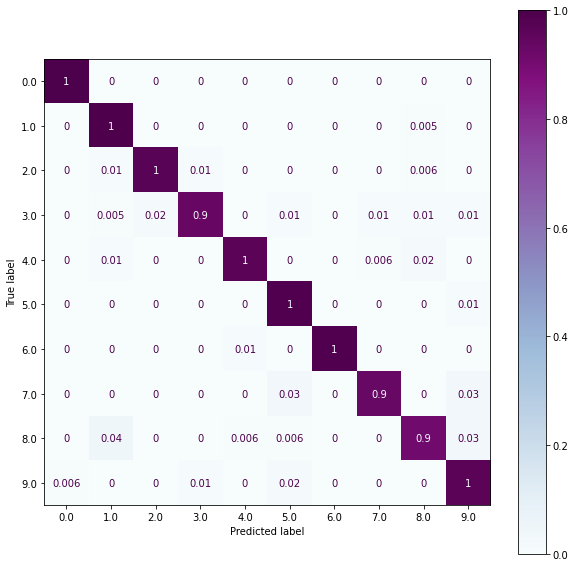

In [17]:
from sklearn.metrics import plot_confusion_matrix
import matplotlib.pyplot as plt
fig, ax = plt.subplots(figsize=(10,10))
plot_confusion_matrix(best_lreg, X_test, y_test, normalize = 'true', cmap = 'BuPu', values_format= '.1g', ax = ax)
plt.savefig('./fig/conf_mat.pdf')